<a href="https://colab.research.google.com/github/AdnaneMOUZAOUI/Analyse-de-sentiments-machine-learning/blob/Reviews-Analysis/NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importer le fichier depuis le drive
import pandas as pd

df = pd.read_csv('showroom_trustpilot_168897_07 mars.csv')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import re
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [ ]:
df=df.rename(columns={"nom_client":"client","date_achat":"date_commande","date_avis":"date","text_avis":"Commentaire","titre_avis":"Titre","note_avis":"star"})

In [ ]:
df.iloc[0]

client                                                       Agani
star                                                             1
date_commande                                       : 26 août 2022
date                                                    2023-02-27
nbr_avis                                                         2
Commentaire      Je n’ai jamais reçu ma commande. J’ai écris à ...
pays                                                            FR
Titre                              Je n’ai jamais reçu ma commande
Name: 0, dtype: object

In [ ]:
# Comptage et transformation des commentaires

from collections import Counter
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import ngrams
from tqdm import tqdm

lemmatizer = WordNetLemmatizer()

commentaires = pd.Series(df['Commentaire'])
stop_words = set(stopwords.words('french'))
stop_words.update(['a', "jai", "cest", "sest", "car", "donc"])

def clean_text(text):
    text = " ".join(text.split()) # supprimer les espaces superflus
    text = text.lower() # mettre les mots en minuscule
    text = text.translate(str.maketrans('', '', string.punctuation)) # retirer les ponctuations
    return text

def count_words(text):
    return len(text.split())

# Calculer la longueur de chaque commentaire
df['longueur'] = commentaires.apply(lambda x: len(x) if isinstance(x, str) else 0)

# Calculer le nombre de majuscules dans chaque commentaire
df['majuscule'] = commentaires.apply(lambda x: sum(1 for c in x if c.isupper()) if isinstance(x, str) else 0)

# Calculer le nombre de points d'exclamation et d'interrogation dans chaque commentaire
df['ponct'] = commentaires.apply(lambda x: x.count('!') + x.count('?') if isinstance(x, str) else 0)

# Compter le nombre de mots dans chaque commentaire
df['nb_mots'] = commentaires.apply(lambda x: count_words(x) if isinstance(x, str) else 0)

# Nettoyer le texte de chaque commentaire, lemmatiser et compter la fréquence des mots
for x in tqdm(range(0,df.shape[0])):
    try:
        filtered_sentence = []
        commentaires[x] = clean_text(commentaires[x])
        word_tokens = word_tokenize(commentaires[x], language="french")
        for w in word_tokens:
            if not w in stop_words and w.isalpha():
                lemma = lemmatizer.lemmatize(w)
                filtered_sentence.append(lemma)
        commentaires[x] = filtered_sentence
    except:
        commentaires[x] = ""


df['Commentaire'] = commentaires


# Créer des n-grammes de taille 2 et 3
df['ngram_2'] = commentaires.apply(lambda x: list(ngrams(x, 2)) if isinstance(x, list) else [])
df['ngram_3'] = commentaires.apply(lambda x: list(ngrams(x, 3)) if isinstance(x, list) else [])

# Compter la fréquence
compteur_mots = Counter()
compteur_ngrams_2 = Counter()
compteur_ngrams_3 = Counter()

for x in range(0,df.shape[0]):
    mots = df.loc[x, 'Commentaire']
    ngrams_2 = df.loc[x, 'ngram_2']
    ngrams_3 = df.loc[x, 'ngram_3']
    compteur_mots.update(mots)
    compteur_ngrams_2.update(ngrams_2)
    compteur_ngrams_3.update(ngrams_3)

print("20 mots les plus communs :")
for Commentaire, frequence in compteur_mots.most_common(20):
    print(Commentaire, frequence)

print("\n 20 2-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_2.most_common(20):
    print(ngram, frequence)

print("\n 20 3-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_3.most_common(20):
    print(ngram, frequence)

100%|████████████████████████████████████████████████████████████████████████| 168897/168897 [00:43<00:00, 3847.68it/s]


20 mots les plus communs :
commande 56221
livraison 48559
très 42398
bien 25659
colis 25619
site 24226
plus 23735
produits 21646
produit 21337
article 18585
qualité 16756
tout 16474
bon 16045
reçu 15087
délais 13681
prix 13328
trop 12925
long 12839
toujours 12055
peu 11873

 20 2-ngrams les plus communs :
('délai', 'livraison') 5899
('très', 'bien') 5658
('délais', 'livraison') 5497
('trop', 'long') 4766
('service', 'client') 4570
('point', 'relais') 4465
('très', 'bon') 4103
('bonne', 'qualité') 3820
('frais', 'port') 3758
('très', 'satisfaite') 3511
('peu', 'long') 3466
('rien', 'dire') 3240
('date', 'lexpérience') 2935
('livraison', 'trop') 2910
('livraison', 'peu') 2832
('bien', 'passé') 2613
('produit', 'conforme') 2447
('bon', 'site') 2418
('cette', 'commande') 2320
('bon', 'produit') 2301

 20 3-ngrams les plus communs :
('livraison', 'trop', 'long') 1587
('livraison', 'peu', 'long') 1364
('très', 'bon', 'site') 1334
('tout', 'bien', 'passé') 1221
('rapport', 'qualité', 'prix') 

In [ ]:
# Comptage et transformation des titres

from collections import Counter
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import ngrams
from tqdm import tqdm

lemmatizer = WordNetLemmatizer()

commentaires = pd.Series(df['Titre'])
stop_words = set(stopwords.words('french'))
stop_words.update(['a', "jai", "cest", "sest", "car", "donc"])

def clean_text(text):
    text = " ".join(text.split()) # supprimer les espaces superflus
    text = text.lower() # mettre les mots en minuscule
    text = text.translate(str.maketrans('', '', string.punctuation)) # retirer les ponctuations
    return text

def count_words(text):
    return len(text.split())

# Calculer la longueur de chaque commentaire
df['longueur_titre'] = commentaires.apply(lambda x: len(x) if isinstance(x, str) else 0)

# Calculer le nombre de majuscules dans chaque commentaire
df['majuscule_titre'] = commentaires.apply(lambda x: sum(1 for c in x if c.isupper()) if isinstance(x, str) else 0)

# Calculer le nombre de points d'exclamation et d'interrogation dans chaque commentaire
df['ponct_titre'] = commentaires.apply(lambda x: x.count('!') + x.count('?') if isinstance(x, str) else 0)

# Compter le nombre de mots dans chaque commentaire
df['nb_mots_titre'] = commentaires.apply(lambda x: count_words(x) if isinstance(x, str) else 0)

# Nettoyer le texte de chaque commentaire, lemmatiser et compter la fréquence des mots
for x in tqdm(range(0,df.shape[0])):
    try:
        filtered_sentence = []
        commentaires[x] = clean_text(commentaires[x])
        word_tokens = word_tokenize(commentaires[x], language="french")
        for w in word_tokens:
            if not w in stop_words and w.isalpha():
                lemma = lemmatizer.lemmatize(w)
                filtered_sentence.append(lemma)
        commentaires[x] = filtered_sentence
    except:
        commentaires[x] = ""


df['Titre'] = commentaires


# Créer des n-grammes de taille 2 et 3
df['ngram_2_titre'] = commentaires.apply(lambda x: list(ngrams(x, 2)) if isinstance(x, list) else [])
df['ngram_3_titre'] = commentaires.apply(lambda x: list(ngrams(x, 3)) if isinstance(x, list) else [])

# Compter la fréquence
compteur_mots = Counter()
compteur_ngrams_2 = Counter()
compteur_ngrams_3 = Counter()

for x in range(0,df.shape[0]):
    mots = df.loc[x, 'Titre']
    ngrams_2 = df.loc[x, 'ngram_2_titre']
    ngrams_3 = df.loc[x, 'ngram_3_titre']
    compteur_mots.update(mots)
    compteur_ngrams_2.update(ngrams_2)
    compteur_ngrams_3.update(ngrams_3)

print("20 mots les plus communs :")
for Commentaire, frequence in compteur_mots.most_common(20):
    print(Commentaire, frequence)

print("\n 20 2-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_2.most_common(20):
    print(ngram, frequence)

print("\n 20 3-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_3.most_common(20):
    print(ngram, frequence)

100%|████████████████████████████████████████████████████████████████████████| 168897/168897 [00:22<00:00, 7471.71it/s]


20 mots les plus communs :
très 17786
commande 16985
livraison 15925
bien 14459
satisfaite 8805
bon 8780
parfait 7525
produit 6963
site 6822
super 4863
trop 4801
qualité 4418
tres 4372
colis 4223
produits 4052
excellent 3864
long 3846
conforme 3747
déçue 3696
article 3479

 20 2-ngrams les plus communs :
('très', 'bien') 5447
('bon', 'site') 2708
('très', 'bon') 2599
('très', 'satisfaite') 2190
('trop', 'long') 2169
('délai', 'livraison') 1790
('livraison', 'trop') 1790
('bon', 'produit') 1692
('tres', 'bien') 1644
('délais', 'livraison') 1132
('rien', 'dire') 941
('trop', 'longue') 895
('bien', 'passé') 773
('non', 'conforme') 764
('très', 'déçue') 718
('bonne', 'qualité') 707
('rien', 'redire') 689
('peu', 'long') 664
('très', 'contente') 646
('retard', 'livraison') 640

 20 3-ngrams les plus communs :
('très', 'bon', 'site') 1234
('livraison', 'trop', 'long') 864
('livraison', 'trop', 'longue') 602
('rapport', 'qualité', 'prix') 471
('très', 'bon', 'produit') 420
('délai', 'livraiso

In [ ]:

df.to_csv("df_showroom.csv")

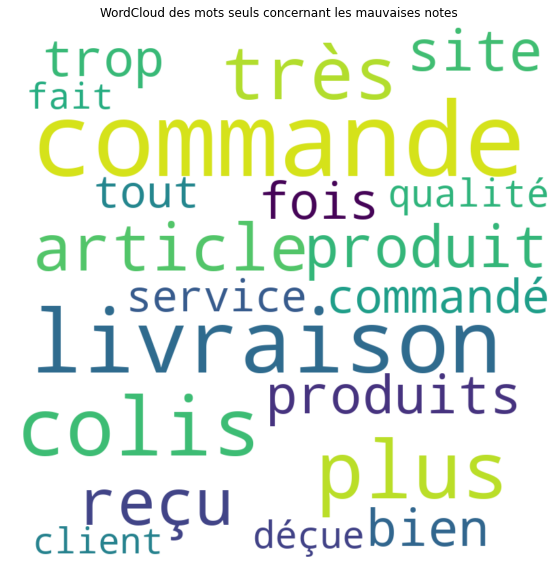

In [ ]:
# Wordclouds pour les mots 1  et star 1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join([' '.join(lst) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['Commentaire']])
wordcloud = WordCloud(background_color = 'white', max_words=20,width=800, height=800, stopwords=[], collocations=False,normalize_plurals=False )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots seuls concernant les mauvaises notes")
plt.show()

wordcloud.to_file("WCbad_1.png")

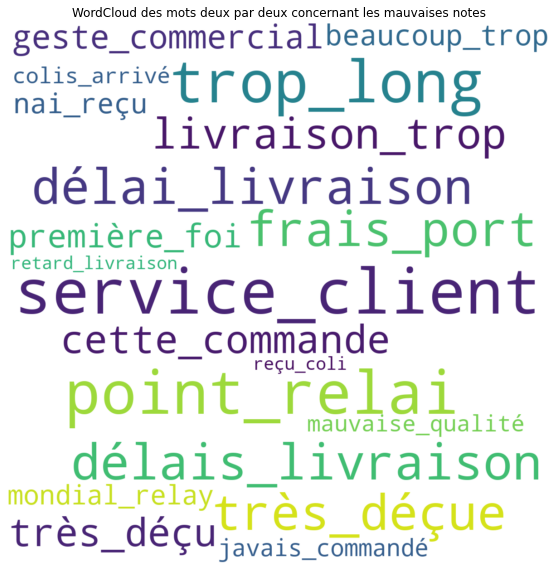

In [ ]:
# wordclouds pour les ngrams pour note =1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['ngram_2'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots deux par deux concernant les mauvaises notes")
plt.show()
wordcloud.to_file("WCbad_2.png")

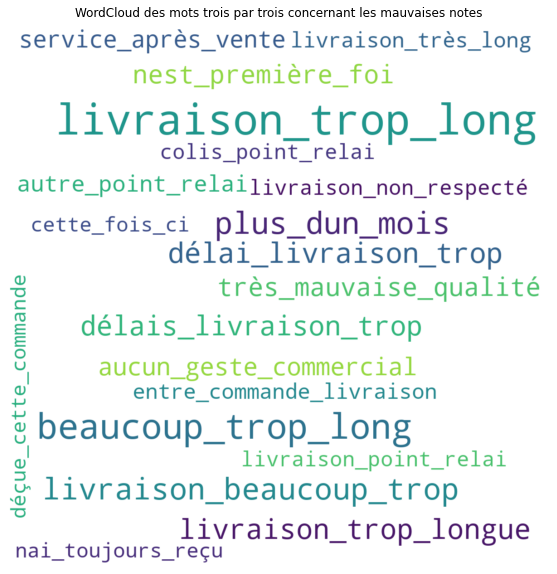

In [ ]:
# wordclouds pour les ngrams pour note =1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['ngram_3'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots trois par trois concernant les mauvaises notes")
plt.show()
wordcloud.to_file("WCbad_3.png")

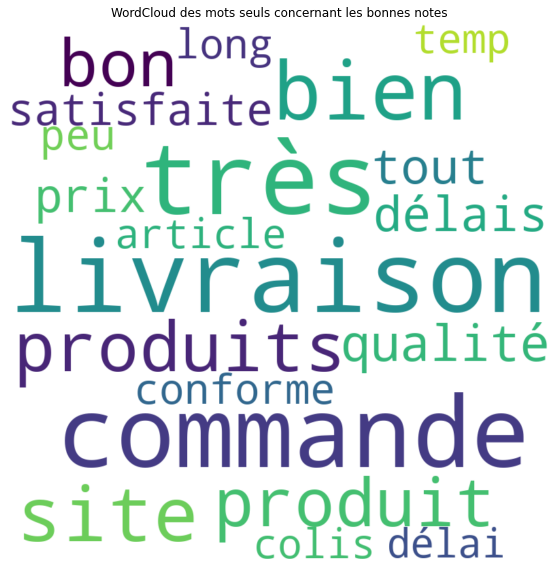

In [ ]:
# Wordclouds pour les mots 1  et star 1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join([' '.join(lst) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['Commentaire']])
wordcloud = WordCloud(background_color = 'white', max_words=20,width=800, height=800, stopwords=[], collocations=False,normalize_plurals=False  )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots seuls concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_1.png")

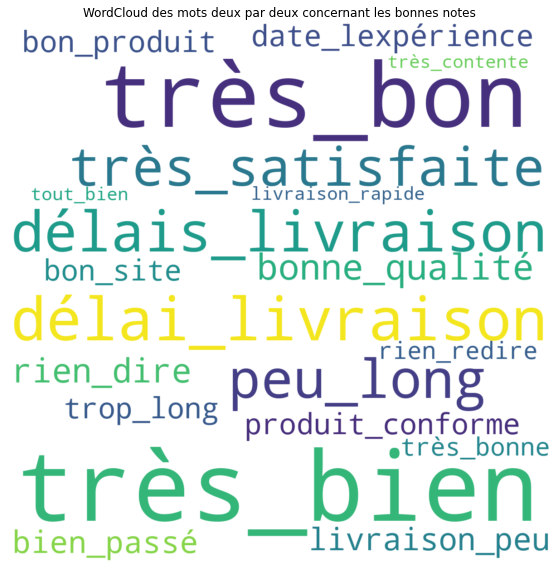

In [ ]:
# wordclouds pour les ngrams pour note =1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['ngram_2'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots deux par deux concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_2.png")

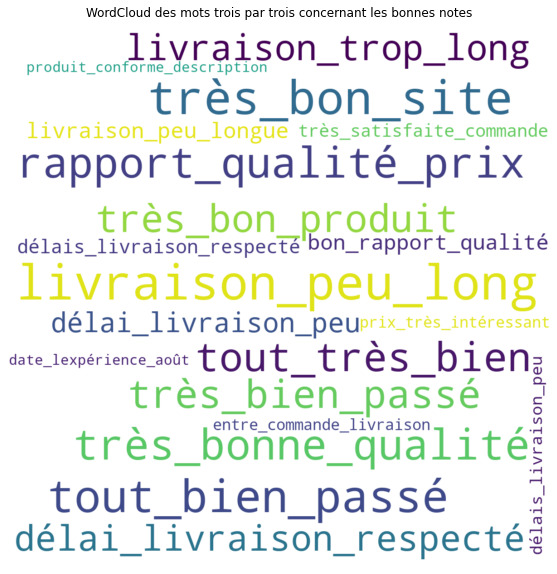

In [ ]:
# wordclouds pour les ngrams pour note =1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['ngram_3'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots trois par trois concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_3.png")

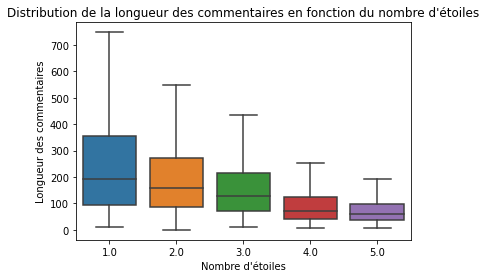

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='star', y='longueur', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Longueur des commentaires")
plt.title("Distribution de la longueur des commentaires en fonction du nombre d'étoiles")

plt.show();

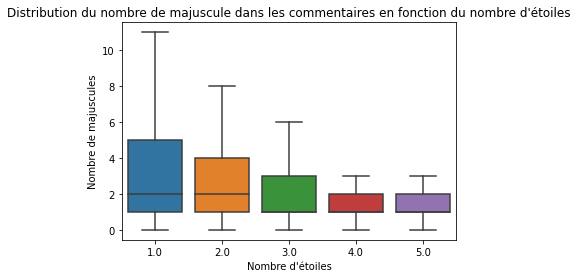

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='star', y='majuscule', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de majuscules")
plt.title("Distribution du nombre de majuscule dans les commentaires en fonction du nombre d'étoiles")

plt.show();

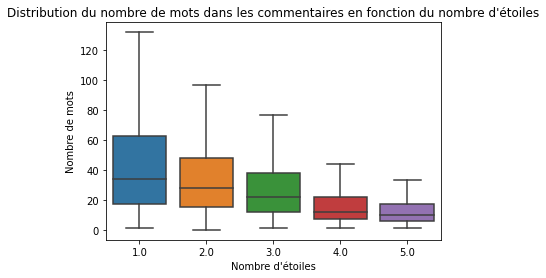

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='star', y='nb_mots', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de mots")
plt.title("Distribution du nombre de mots dans les commentaires en fonction du nombre d'étoiles")

plt.show();

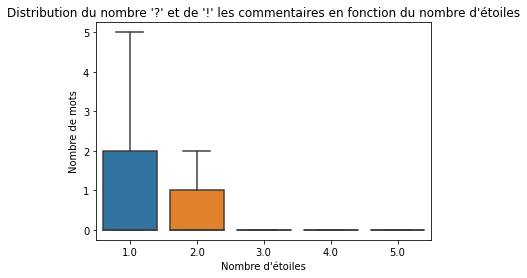

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='star', y='ponct', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de mots")
plt.title("Distribution du nombre '?' et de '!' les commentaires en fonction du nombre d'étoiles")

plt.show();

In [ ]:
df_pair=df.drop(["client","date_commande","date","Commentaire","pays","Titre","ngram_2","ngram_3","ngram_2_titre","ngram_3_titre"],axis=1)

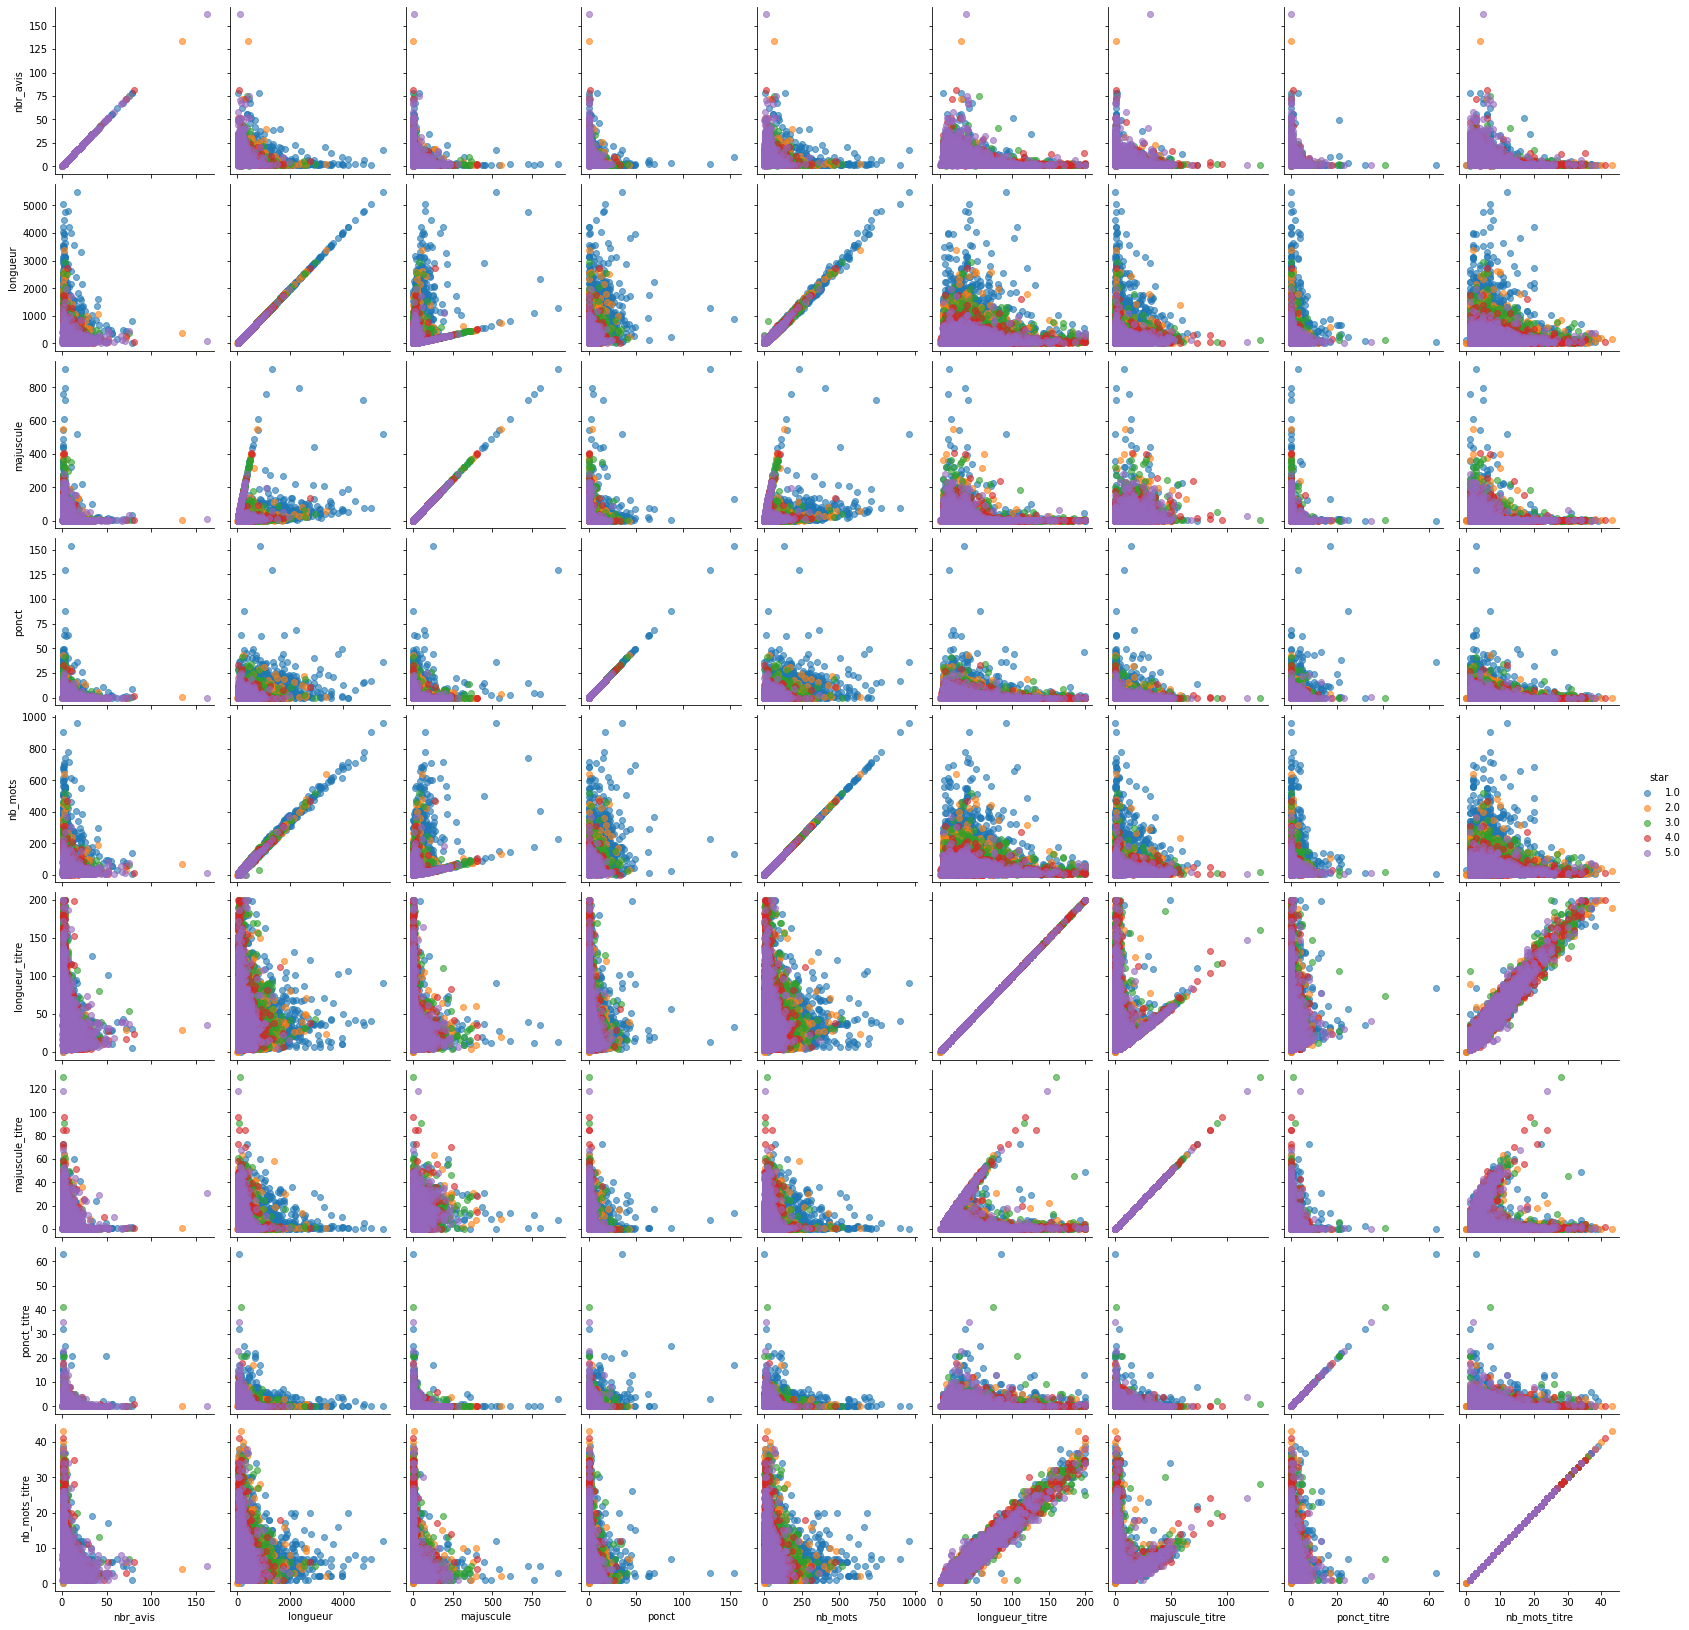

In [ ]:
g=sns.PairGrid(df_pair, hue='star')
g.map(plt.scatter, alpha=0.6)
g.add_legend()

In [ ]:
df.corr()

,star,nbr_avis,longueur,majuscule,ponct,nb_mots,longueur_titre,majuscule_titre,ponct_titre,nb_mots_titre
star,1.000000,0.080158,-0.405823,-0.103718,-0.208811,-0.415711,-0.182322,-0.029035,-0.048556,-0.174929
nbr_avis,0.080158,1.000000,0.034419,0.020846,0.013711,0.030301,0.016242,0.026107,0.007098,0.013539
longueur,-0.405823,0.034419,1.000000,0.289606,0.364695,0.995819,0.184477,0.073678,0.075799,0.159991
majuscule,-0.103718,0.020846,0.289606,1.000000,0.178955,0.286294,0.043340,0.344951,0.031392,0.036977
ponct,-0.208811,0.013711,0.364695,0.178955,1.000000,0.366546,0.059626,0.055330,0.254516,0.054520
nb_mots,-0.415711,0.030301,0.995819,0.286294,0.366546,1.000000,0.182235,0.071416,0.075037,0.161510
longueur_titre,-0.182322,0.016242,0.184477,0.043340,0.059626,0.182235,1.000000,0.083323,0.091269,0.960194
majuscule_titre,-0.029035,0.026107,0.073678,0.344951,0.055330,0.071416,0.083323,1.000000,0.030202,0.074641
ponct_titre,-0.048556,0.007098,0.075799,0.031392,0.254516,0.075037,0.091269,0.030202,1.000000,0.091927
nb_mots_titre,-0.174929,0.013539,0.159991,0.036977,0.054520,0.161510,0.960194,0.074641,0.091927,1.000000


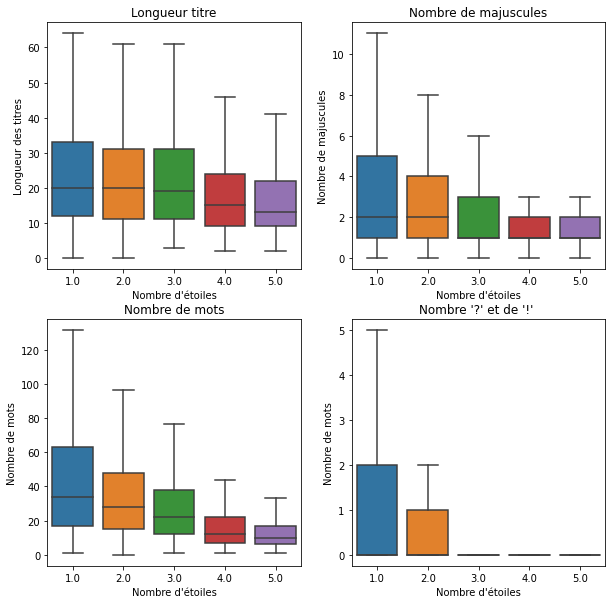

In [ ]:
fig= plt.figure(figsize=(10,10))

plt.subplot(221)
sns.boxplot(x='star', y='longueur_titre', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Longueur des titres")
plt.title("Longueur titre")

plt.subplot(222)
sns.boxplot(x='star', y='majuscule', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de majuscules")
plt.title("Nombre de majuscules")

plt.subplot(223)
sns.boxplot(x='star', y='nb_mots', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de mots")
plt.title("Nombre de mots")

plt.subplot(224)
sns.boxplot(x='star', y='ponct', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de mots")
plt.title("Nombre '?' et de '!' ");

In [ ]:
df[["star","longueur_titre", "majuscule_titre", "ponct_titre", "nb_mots_titre"]].corr()

,star,longueur_titre,majuscule_titre,ponct_titre,nb_mots_titre
star,1.000000,-0.182322,-0.029035,-0.048556,-0.174929
longueur_titre,-0.182322,1.000000,0.083323,0.091269,0.960194
majuscule_titre,-0.029035,0.083323,1.000000,0.030202,0.074641
ponct_titre,-0.048556,0.091269,0.030202,1.000000,0.091927
nb_mots_titre,-0.174929,0.960194,0.074641,0.091927,1.000000


In [ ]:
df_filtre = df[(df['star'] == 1) | (df['star'] == 2) | (df['star'] == 3)].reset_index(drop=True)

compteur_mots = Counter()
compteur_ngrams_2 = Counter()
compteur_ngrams_3 = Counter()

for x in range(df_filtre.shape[0]):
    mots = df_filtre.loc[x, 'Commentaire']
    ngrams_2 = df_filtre.loc[x, 'ngram_2']
    ngrams_3 = df_filtre.loc[x, 'ngram_3']
    compteur_mots.update(mots)
    compteur_ngrams_2.update(ngrams_2)
    compteur_ngrams_3.update(ngrams_3)

print("20 mots les plus communs :")
for Commentaire, frequence in compteur_mots.most_common(20):
    print(Commentaire, frequence)

print("\n 20 2-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_2.most_common(20):
    print(ngram, frequence)

print("\n 20 3-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_3.most_common(20):
    print(ngram, frequence)

20 mots les plus communs :
commande 29600
livraison 21155
colis 18265
plus 17652
très 15066
article 11347
reçu 11055
produit 9801
site 9272
produits 9270
bien 8537
trop 8455
fois 8229
commandé 7920
tout 6953
service 6801
qualité 6520
déçue 6383
fait 5935
client 5825

 20 2-ngrams les plus communs :
('service', 'client') 3737
('point', 'relais') 3218
('trop', 'long') 2872
('délai', 'livraison') 2193
('très', 'déçue') 2189
('frais', 'port') 2131
('délais', 'livraison') 2078
('livraison', 'trop') 1766
('cette', 'commande') 1516
('très', 'déçu') 1384
('geste', 'commercial') 1344
('première', 'fois') 1312
('beaucoup', 'trop') 1237
('nai', 'reçu') 1131
('mondial', 'relay') 1113
('javais', 'commandé') 1055
('mauvaise', 'qualité') 1018
('plus', 'tard') 951
('retard', 'livraison') 950
('reçu', 'colis') 944

 20 3-ngrams les plus communs :
('livraison', 'trop', 'long') 951
('beaucoup', 'trop', 'long') 619
('plus', 'dun', 'mois') 523
('livraison', 'beaucoup', 'trop') 505
('délai', 'livraison', 't

In [ ]:
df_filtre = df[(df['star'] == 4) | (df['star'] == 5)].reset_index(drop=True)

compteur_mots = Counter()
compteur_ngrams_2 = Counter()
compteur_ngrams_3 = Counter()

for x in range(df_filtre.shape[0]):
    mots = df_filtre.loc[x, 'Commentaire']
    ngrams_2 = df_filtre.loc[x, 'ngram_2']
    ngrams_3 = df_filtre.loc[x, 'ngram_3']
    compteur_mots.update(mots)
    compteur_ngrams_2.update(ngrams_2)
    compteur_ngrams_3.update(ngrams_3)

print("20 mots les plus communs :")
for Commentaire, frequence in compteur_mots.most_common(20):
    print(Commentaire, frequence)

print("\n 20 2-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_2.most_common(20):
    print(ngram, frequence)

print("\n 20 3-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_3.most_common(20):
    print(ngram, frequence)

20 mots les plus communs :
livraison 27404
très 27332
commande 26621
bien 17122
site 14954
produits 12376
produit 11536
bon 11171
qualité 10236
tout 9521
délais 9500
prix 8931
satisfaite 8875
peu 7851
conforme 7752
temp 7417
long 7383
colis 7354
article 7238
délai 7108

 20 2-ngrams les plus communs :
('très', 'bien') 4793
('très', 'bon') 3752
('délai', 'livraison') 3706
('délais', 'livraison') 3419
('très', 'satisfaite') 3226
('bonne', 'qualité') 3146
('peu', 'long') 3039
('rien', 'dire') 2776
('livraison', 'peu') 2472
('bien', 'passé') 2412
('date', 'lexpérience') 2204
('bon', 'site') 2167
('produit', 'conforme') 2164
('trop', 'long') 1894
('bon', 'produit') 1872
('rien', 'redire') 1858
('livraison', 'rapide') 1738
('très', 'contente') 1712
('tout', 'bien') 1706
('qualité', 'prix') 1705

 20 3-ngrams les plus communs :
('très', 'bon', 'site') 1246
('livraison', 'peu', 'long') 1200
('tout', 'bien', 'passé') 1145
('rapport', 'qualité', 'prix') 1009
('très', 'bonne', 'qualité') 988
('to

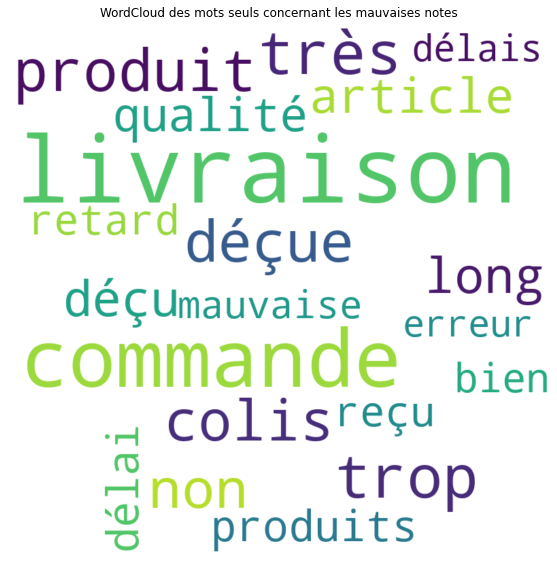

In [ ]:
# Wordclouds pour les mots 1  et star 1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join([' '.join(lst) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['Titre']])
wordcloud = WordCloud(background_color = 'white', max_words=20,width=800, height=800, stopwords=[], collocations=False,normalize_plurals=False )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots seuls concernant les mauvaises notes")
plt.show()

wordcloud.to_file("WCbad_1_titre.png")

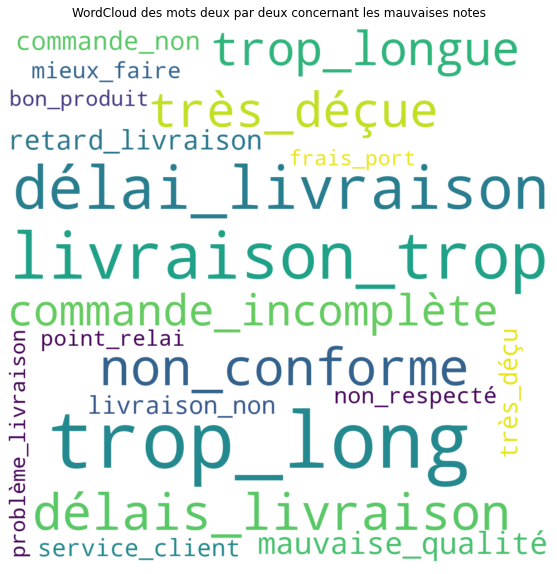

In [ ]:
# wordclouds pour les ngrams pour note =1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['ngram_2_titre'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots deux par deux concernant les mauvaises notes")
plt.show()
wordcloud.to_file("WCbad_2_titre.png")

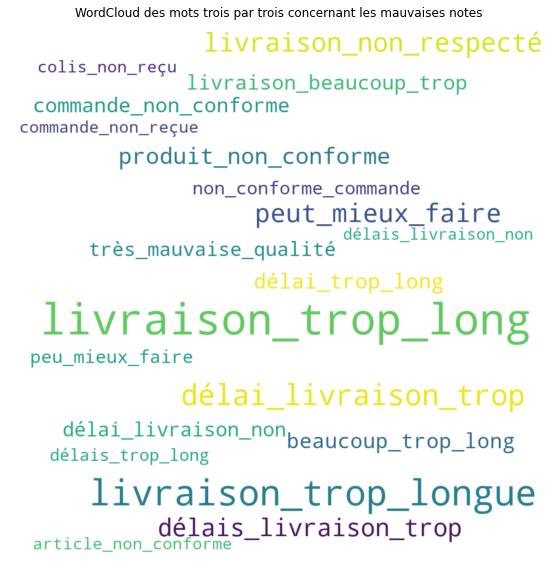

In [ ]:
# wordclouds pour les ngrams pour note =1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['ngram_3_titre'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots trois par trois concernant les mauvaises notes")
plt.show()
wordcloud.to_file("WCbad_3_titre.png")

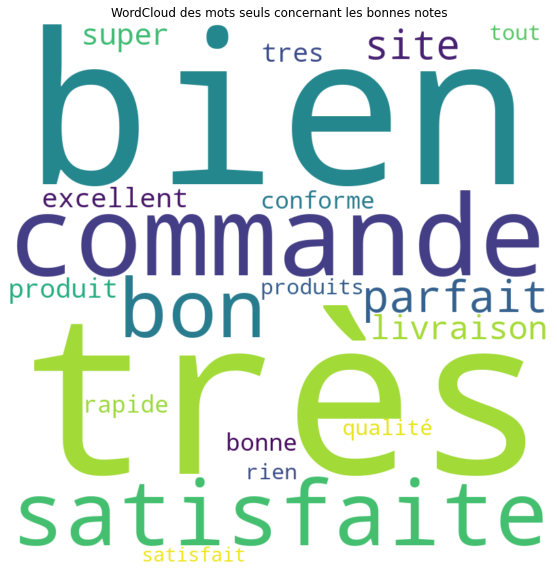

In [ ]:
# Wordclouds pour les mots 1  et star 1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join([' '.join(lst) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['Titre']])
wordcloud = WordCloud(background_color = 'white', max_words=20,width=800, height=800, stopwords=[], collocations=False,normalize_plurals=False  )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots seuls concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_1_titre.png")

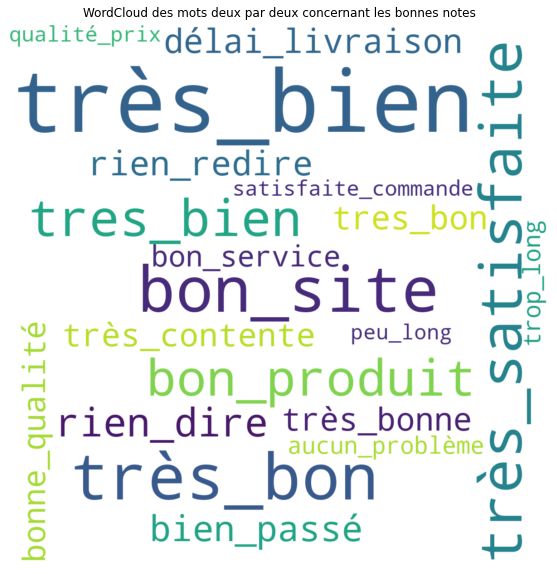

In [ ]:
# wordclouds pour les ngrams pour note =1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['ngram_2_titre'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots deux par deux concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_2_titre.png")

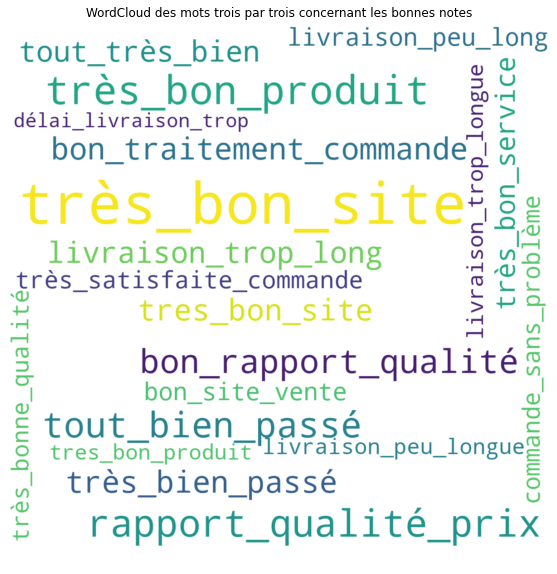

In [ ]:
# wordclouds pour les ngrams pour note =1
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['ngram_3_titre'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots trois par trois concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_3_titre.png")

In [ ]:
df_filtre = df[(df['star'] == 1) | (df['star'] == 2) | (df['star'] == 3)].reset_index(drop=True)

compteur_mots = Counter()
compteur_ngrams_2 = Counter()
compteur_ngrams_3 = Counter()

for x in range(df_filtre.shape[0]):
    mots = df_filtre.loc[x, 'Titre']
    ngrams_2 = df_filtre.loc[x, 'ngram_2_titre']
    ngrams_3 = df_filtre.loc[x, 'ngram_3_titre']
    compteur_mots.update(mots)
    compteur_ngrams_2.update(ngrams_2)
    compteur_ngrams_3.update(ngrams_3)

print("20 mots les plus communs :")
for Commentaire, frequence in compteur_mots.most_common(20):
    print(Commentaire, frequence)

print("\n 20 2-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_2.most_common(20):
    print(ngram, frequence)

print("\n 20 3-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_3.most_common(20):
    print(ngram, frequence)

20 mots les plus communs :
livraison 10078
commande 7297
très 3669
trop 3659
produit 3434
déçue 3326
colis 3244
non 3058
long 2458
déçu 2376
article 2324
qualité 2178
délai 1883
produits 1848
retard 1753
reçu 1747
bien 1645
mauvaise 1469
erreur 1357
délais 1350

 20 2-ngrams les plus communs :
('trop', 'long') 1670
('livraison', 'trop') 1344
('délai', 'livraison') 1132
('délais', 'livraison') 748
('non', 'conforme') 747
('très', 'déçue') 713
('trop', 'longue') 674
('commande', 'incomplète') 590
('mauvaise', 'qualité') 578
('retard', 'livraison') 567
('commande', 'non') 517
('livraison', 'non') 469
('très', 'déçu') 456
('service', 'client') 453
('mieux', 'faire') 388
('frais', 'port') 346
('point', 'relais') 334
('problème', 'livraison') 333
('non', 'respecté') 315
('bon', 'produit') 299

 20 3-ngrams les plus communs :
('livraison', 'trop', 'long') 634
('livraison', 'trop', 'longue') 458
('délai', 'livraison', 'trop') 291
('peut', 'mieux', 'faire') 220
('délais', 'livraison', 'trop') 2

In [ ]:
df_filtre = df[(df['star'] == 4) | (df['star'] == 5)].reset_index(drop=True)

compteur_mots = Counter()
compteur_ngrams_2 = Counter()
compteur_ngrams_3 = Counter()

for x in range(df_filtre.shape[0]):
    mots = df_filtre.loc[x, 'Titre']
    ngrams_2 = df_filtre.loc[x, 'ngram_2_titre']
    ngrams_3 = df_filtre.loc[x, 'ngram_3_titre']
    compteur_mots.update(mots)
    compteur_ngrams_2.update(ngrams_2)
    compteur_ngrams_3.update(ngrams_3)

print("20 mots les plus communs :")
for Commentaire, frequence in compteur_mots.most_common(20):
    print(Commentaire, frequence)

print("\n 20 2-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_2.most_common(20):
    print(ngram, frequence)

print("\n 20 3-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_3.most_common(20):
    print(ngram, frequence)

20 mots les plus communs :
très 14117
bien 12814
commande 9688
satisfaite 7806
bon 7643
parfait 7426
site 5948
livraison 5847
super 4713
excellent 3836
tres 3578
produit 3529
rapide 2749
bonne 2697
conforme 2627
qualité 2240
produits 2204
rien 2184
tout 2183
satisfait 1762

 20 2-ngrams les plus communs :
('très', 'bien') 5328
('bon', 'site') 2543
('très', 'bon') 2514
('très', 'satisfaite') 2138
('tres', 'bien') 1616
('bon', 'produit') 1393
('rien', 'dire') 919
('bien', 'passé') 750
('rien', 'redire') 683
('délai', 'livraison') 658
('très', 'contente') 620
('tres', 'bon') 605
('bonne', 'qualité') 582
('bon', 'service') 573
('aucun', 'problème') 560
('qualité', 'prix') 552
('très', 'bonne') 548
('tout', 'bien') 507
('peu', 'long') 504
('trop', 'long') 499

 20 3-ngrams les plus communs :
('très', 'bon', 'site') 1206
('rapport', 'qualité', 'prix') 417
('très', 'bon', 'produit') 401
('tout', 'bien', 'passé') 367
('bon', 'rapport', 'qualité') 322
('très', 'bien', 'passé') 268
('tres', 'bon

# Préparation modélisation

In [ ]:
# Création d'une nouvelle variable "star_cluster" pour séparer le jeu de données en 2 segments,
# le segment des avis positifs (=1) et le segment des avis négatifs (=0)
df['star_cluster'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)

In [ ]:
# réinitialisation des compteurs
compteur_mots_com = Counter()
compteur_ngrams_2_com = Counter()
compteur_ngrams_3_com = Counter()
compteur_mots_titre = Counter()
compteur_ngrams_2_titre = Counter()
compteur_ngrams_3_titre = Counter()

for x in range(0,df.shape[0]):
    mots = df.loc[x, 'Commentaire']
    ngrams_2 = df.loc[x, 'ngram_2']
    ngrams_3 = df.loc[x, 'ngram_3']
    compteur_mots_com.update(mots)
    compteur_ngrams_2_com.update(ngrams_2)
    compteur_ngrams_3_com.update(ngrams_3)
    mots_t = df.loc[x, 'Titre']
    ngrams_2_t = df.loc[x, 'ngram_2_titre']
    ngrams_3_t = df.loc[x, 'ngram_3_titre']
    compteur_mots_titre.update(mots_t)
    compteur_ngrams_2_titre.update(ngrams_2_t)
    compteur_ngrams_3_titre.update(ngrams_3_t)



In [ ]:
# Dichotomisation des Commentaires
df['Commentaire'].fillna('', inplace=True)

mots_cles = [mot for mot, _ in compteur_mots_com.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition

for mot in mots_cles:
    df['Commentaire_'+mot] = df['Commentaire'].apply(lambda x: int(mot in x)) #int pour convertir le booléen en entier


# Dichotomisation des ngrams2

df['ngram_2'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_ngrams_2_com.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition

# Créer une colonne pour chaque tuples clés
for mot in mots_cles:
    df['ngrams_2_'+str(mot)] = df['ngram_2'].apply(lambda x: int(any(mot == t for t in x)))

# Dichotomiser les ngrams2
dummies = pd.get_dummies(df[['ngrams_2_'+str(mot) for mot in mots_cles]])

# Ajouter les colonnes dichotomisées à la dataframe
df = pd.concat([df, dummies], axis=1)


# Dichotomisation des ngrams3
df['ngram_3'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_ngrams_3_com.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition

# Créer une colonne pour chaque tuples clés
for mot in mots_cles:
    df['ngrams_3_'+str(mot)] = df['ngram_3'].apply(lambda x: int(any(mot == t for t in x)))

# Dichotomiser les ngrams3
dummies = pd.get_dummies(df[['ngrams_3_'+str(mot) for mot in mots_cles]])

# Ajouter les colonnes dichotomisées à la dataframe
df = pd.concat([df, dummies], axis=1)




# Dichotomisation des titre
df['Titre'].fillna('', inplace=True)

mots_cles = [mot for mot, _ in compteur_mots_titre.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition

for mot in mots_cles:
    df['Titre_'+mot] = df['Titre'].apply(lambda x: int(mot in x)) #int pour convertir le booléen en entier


# Dichotomisation des ngrams2

df['ngram_2_titre'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_ngrams_2_titre.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition

# Créer une colonne pour chaque tuples clés
for mot in mots_cles:
    df['ngrams_2_titre_'+str(mot)] = df['ngram_2'].apply(lambda x: int(any(mot == t for t in x)))

# Dichotomiser les ngrams2
dummies = pd.get_dummies(df[['ngrams_2_titre_'+str(mot) for mot in mots_cles]])

# Ajouter les colonnes dichotomisées à la dataframe
df = pd.concat([df, dummies], axis=1)


# Dichotomisation des ngrams3
df['ngram_3_titre'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_ngrams_3_titre.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition

# Créer une colonne pour chaque tuples clés
for mot in mots_cles:
    df['ngrams_3_titre'+str(mot)] = df['ngram_3_titre'].apply(lambda x: int(any(mot == t for t in x)))

# Dichotomiser les ngrams3
dummies = pd.get_dummies(df[['ngrams_3_titre'+str(mot) for mot in mots_cles]])

# Ajouter les colonnes dichotomisées à la dataframe
df = pd.concat([df, dummies], axis=1)


C:\Users\f.rouxelin\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [ ]:

df.to_csv('data_preparee.csv')

In [ ]:
df=df_save

NameError: name 'df_save' is not defined

In [ ]:
df=df.drop(columns=['client', 'star', 'date_commande', 'date', 'pays', 'Commentaire', 'Titre', 'ngram_2', 'ngram_3', 'ngram_2_titre', 'ngram_3_titre'], axis=1)
df=df.dropna(axis=0,how='any')

In [ ]:
y=df['star_cluster']

In [ ]:
X=df.drop('star_cluster',1)

In [ ]:

variables_continues=['nbr_avis', 'longueur', 'majuscule', 'ponct', 'nb_mots',
       'longueur_titre', 'majuscule_titre', 'ponct_titre', 'nb_mots_titre']

scaler = StandardScaler()
minmax = MinMaxScaler()

X_ss=X
X_ss.loc[:, variables_continues] = scaler.fit_transform(X_ss.loc[:, variables_continues])

X_mms=X
X_mms.loc[:, variables_continues] = minmax.fit_transform(X_mms.loc[:, variables_continues])

In [ ]:
X_ss.describe()


In [ ]:
X_train_mms, X_test_mms, y_train, y_test = train_test_split(X_mms,y,test_size = 0.2, random_state=42)
X_train_ss, X_test_ss, y_train, y_test = train_test_split(X_ss,y,test_size = 0.2, random_state=42)

In [ ]:
pca_mms = PCA()
pca_mms.fit(X_mms)

plt.figure()
plt.xlim(0,100)
plt.plot(pca_mms.explained_variance_ratio_);

plt.figure()
plt.xlim(0,100)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca_mms.explained_variance_ratio_.cumsum());

In [ ]:
pca_mms = PCA(n_components = 0.9)
pca_mms.fit(X_mms)
print("Nombre de composantes retenues mms :", pca_mms.n_components_)
X_train_pca_mms = pca_mms.fit_transform(X_train_mms)
X_test_pca_mms = pca_mms.transform(X_test_mms)

pca_ss = PCA(n_components = 0.9)
pca_ss.fit(X_ss)
print("Nombre de composantes retenues ss :", pca_ss.n_components_)
X_train_pca_ss = pca_ss.fit_transform(X_train_ss)
X_test_pca_ss = pca_ss.transform(X_test_ss)

In [ ]:
# RandomForest mms
RFC = RandomForestClassifier(n_jobs = -1)
RFC.fit(X_train_pca_mms, y_train)
RFC.score(X_test_pca_mms, y_test)

In [ ]:
# RandomForest ss
RFC = RandomForestClassifier(n_jobs = -1)
RFC.fit(X_train_pca_ss, y_train)
RFC.score(X_test_pca_ss, y_test)

In [ ]:
# df.to_excel('donnees.xlsx', index=False)